In [1]:
import pandas as pd
import tensorflow as tf
import re
import nltk
import preprocessor as p
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import json


2023-04-15 19:12:05.361026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 19:12:05.680582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cuda/lib64:
2023-04-15 19:12:05.680609: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-15 19:12:06.816065: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object fi

In [2]:
df_twitter = pd.read_csv('./datasets/short.csv', encoding='latin-1', header=None)
df_twitter = df_twitter.drop(df_twitter.index[0])
# df_twitter = df_twitter.sample(frac=0.08)
df_twitter = df_twitter.rename(columns={3: 'Label', 1: 'Text'})
df_twitter.head()

,0,Text,2,Label
1,0.0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
2,2.0,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,3.0,Rwanda is set to host the headquarters of Unit...,en,positive
4,4.0,OOPS. I typed her name incorrectly (todayâs ...,en,litigious
5,5.0,It sucks for me since I'm focused on the natur...,en,negative


In [3]:
df_imdb = pd.read_csv('./datasets/imdb_dataset.csv', header=None)
df_imdb = df_imdb.drop(df_imdb.index[0])
# df_imdb = df_imdb.sample(frac=0.08)
df_imdb = df_imdb.rename(columns={1: 'Label', 0: 'Text'})
df_imdb.head()

,Text,Label
1,One of the other reviewers has mentioned that ...,positive
2,A wonderful little production. <br /><br />The...,positive
3,I thought this was a wonderful way to spend ti...,positive
4,Basically there's a family where a little boy ...,negative
5,"Petter Mattei's ""Love in the Time of Money"" is...",positive


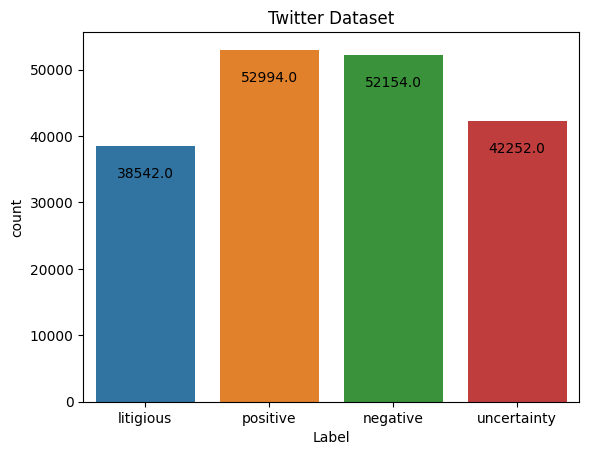

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load example data
plt.close("all")

# Create countplot
ax = sns.countplot(x="Label", data=df_twitter)

# Add count values to the plot
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, -20), 
                textcoords = 'offset points')

# give the name to plot
plt.title('Twitter Dataset')
plt.show()

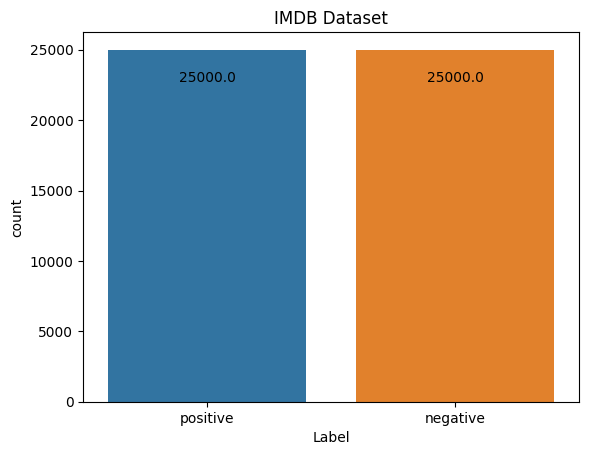

In [5]:
plt.close("all")

# Create countplot
ax = sns.countplot(x="Label", data=df_imdb)

# Add count values to the plot
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, -20), 
                textcoords = 'offset points')

# give the name to plot
plt.title('IMDB Dataset')
plt.show()

# Data preprocessing

In [6]:
# Transforming abbreviations
abbreviations = {
    u"he's": "he is", 
    u"there's": "there is", 
    u"We're": "We are", 
    u"That's": "That is", 
    u"won't": "will not", 
    u"they're": "they are", 
    u"Can't": "Cannot", 
    u"wasn't": "was not", 
    u"don\x89Ûªt": "do not", 
    u"aren't": "are not", 
    u"isn't": "is not", 
    u"What's": "What is", 
    u"haven't": "have not", 
    u"hasn't": "has not", 
    u"There's": "There is", 
    u"He's": "He is", 
    u"It's": "It is", 
    u"You're": "You are", 
    u"I'M": "I am", 
    u"shouldn't": "should not", 
    u"wouldn't": "would not", 
    u"i'm": "I am", 
    u"I\x89Ûªm": "I am", 
    u"I'm": "I am", 
    u"Isn't": "is not", 
    u"Here's": "Here is", 
    u"you've": "you have", 
    u"you\x89Ûªve": "you have", 
    u"we're": "we are", 
    u"what's": "what is", 
    u"couldn't": "could not", 
    u"we've": "we have", 
    u"it\x89Ûªs": "it is", 
    u"doesn\x89Ûªt": "does not", 
    u"It\x89Ûªs": "It is", 
    u"Here\x89Ûªs": "Here is", 
    u"who's": "who is", 
    u"I\x89Ûªve": "I have", 
    u"y'all": "you all", 
    u"can\x89Ûªt": "cannot", 
    u"would've": "would have", 
    u"it'll": "it will", 
    u"we'll": "we will", 
    u"wouldn\x89Ûªt": "would not", 
    u"We've": "We have", 
    u"he'll": "he will", 
    u"Y'all": "You all", 
    u"Weren't": "Were not", 
    u"Didn't": "Did not", 
    u"they'll": "they will", 
    u"they'd": "they would", 
    u"DON'T": "DO NOT", 
    u"That\x89Ûªs": "That is", 
    u"they've": "they have", 
    u"i'd": "I would", 
    u"should've": "should have", 
    u"You\x89Ûªre": "You are", 
    u"where's": "where is", 
    u"Don\x89Ûªt": "Do not", 
    u"we'd": "we would", 
    u"i'll": "I will", 
    u"weren't": "were not", 
    u"They're": "They are", 
    u"Can\x89Ûªt": "Cannot", 
    u"you\x89Ûªll": "you will", 
    u"I\x89Ûªd": "I would", 
    u"let's": "let us", 
    u"it's": "it is", 
    u"can't": "cannot", 
    u"don't": "do not", 
    u"you're": "you are", 
    u"i've": "I have", 
    u"that's": "that is", 
    u"i'll": "I will", 
    u"doesn't": "does not",
    u"i'd": "I would", 
    u"didn't": "did not", 
    u"ain't": "am not", 
    u"you'll": "you will", 
    u"I've": "I have", 
    u"Don't": "do not", 
    u"I'll": "I will", 
    u"I'd": "I would", 
    u"Let's": "Let us", 
    u"you'd": "You would", 
    u"It's": "It is", 
    u"Ain't": "am not", 
    u"Haven't": "Have not", 
    u"Could've": "Could have", 
    u"youve": "you have",   
    u"donå«t": "do not", 
}
 
def transform_abb(text):
    for emot in abbreviations:
        text = re.sub(u'('+emot+')', " ".join(abbreviations[emot].replace(",","").split()), text)
    return text

In [7]:
from googletrans import Translator

translator = Translator()

def translate_text(text):
    translated = translator.translate(text, dest='en')
    return translated.text



In [8]:
import nltk
from nltk.stem import PorterStemmer

stop_words = ['a', 'about', 'above', 'after', 'again', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', 'd', 'did', 'do', 'does', 'doing', 'don', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', 'has', 'hasn', 'have', 'having', 'he', "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', 'more', 'most', 'mustn', 'my', 'myself', 'needn', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', 'she', "she's", 'should', "should've", 'shouldn', 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these', 'they', 'this', 'those', 'through', 'to', 'under', 'until', 'up', 've', 'was', 'wasn', 'we', 'were', 'weren', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', 'wouldn', 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']
def remove_stop_words(text):
    words = text.split(' ')
    arr = [w for w in words if not w in stop_words]
    return ' '.join(arr)

def clean_text(text):
    text = re.sub(r'http[^ ]* ', '', text)
    text = re.sub(r'#\S* ', '', text)
    text = re.sub(r'@\S* ', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s\s+', ' ', text)
    text = text.lower()
    text = transform_abb(text)
    text = remove_stop_words(text)
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text


In [9]:
# texts_twitter = [clean_text(x) for x in df_twitter['Text']]
# texts_imdb = [clean_text(x) for x in df_imdb['Text']]
classes_twitter = ['Positive', 'Negative', "Litigious", "Uncertainity"]
classes_imdb = ['Positive', 'Negative']

labels_twitter = []
labels_imdb = []
for s in df_twitter['Label']:
    arr = np.zeros(4)
    i = 0
    if s == 'negative':
        i = 1
    elif s == 'litigious':
        i = 2
    elif s == 'uncertainty':
        i = 3
    arr[i] = 1.0
    labels_twitter.append(arr)

for s in df_imdb['Label']:
    arr = np.zeros(2)
    i = 0
    if s == 'negative':
        i = 1
    arr[i] = 1.0
    labels_imdb.append(arr)

# save the texts_twitter and labels_twitter in json format
# with open('./data/twitter.json', 'w') as f:
#     json.dump({'texts': texts_twitter}, f)

# # save the texts_imdb and labels_imdb in json format
# with open('./data/imdb.json', 'w') as f:
#     json.dump({'texts': texts_imdb}, f)



         

In [10]:
# load the texts_twitter
with open('./data/twitter.json', 'r') as f:
    data = json.load(f)
    texts_twitter = data['texts']

# load the texts_imdb
with open('./data/imdb.json', 'r') as f:
    data = json.load(f)
    texts_imdb = data['texts']

In [11]:
vocab_size = 30000
embedding_dim = 32
max_length = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

X_train_twit, X_test_twit, y_train_twit, y_test_twit = train_test_split(texts_twitter, labels_twitter, test_size=0.20, random_state=93)
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(texts_imdb, labels_imdb, test_size=0.20, random_state=39)



# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# tokenizer.fit_on_texts(X_train_twit + X_train_imdb)

# Load the tokenizer from file using pickle
with open('./models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Save the tokenizer to a file using pickle
# with open('./models/tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index

X_train_twit = tokenizer.texts_to_sequences(X_train_twit)
X_train_twit = pad_sequences(X_train_twit, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_train_imdb = tokenizer.texts_to_sequences(X_train_imdb)
X_train_imdb = pad_sequences(X_train_imdb, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_test_twit = tokenizer.texts_to_sequences(X_test_twit)
X_test_twit = pad_sequences(X_test_twit, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_test_imdb = tokenizer.texts_to_sequences(X_test_imdb)
X_test_imdb = pad_sequences(X_test_imdb, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [12]:
# # Convert the dictionary to a JSON string
# json_str = json.dumps(word_index)

# # Write the JSON string to a file
# with open('tokens.json', 'w') as f:
#     f.write(json_str)

In [13]:
X_train_twit = np.array(X_train_twit)
y_train_twit = np.array(y_train_twit)
X_test_twit = np.array(X_test_twit)
y_test_twit = np.array(y_test_twit)

X_train_imdb = np.array(X_train_imdb)
y_train_imdb = np.array(y_train_imdb)
X_test_imdb = np.array(X_test_imdb)
y_test_imdb = np.array(y_test_imdb)


In [14]:
models_twit = []
data_twit = []
models_imdb = []
data_imdb = []
total_epochs = 8

# Simple ANN Model

In [15]:
# For Twitter model
models_twit.append("Simple ANN on Twitter")
# simple_ann_model_twit = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(4, activation='sigmoid')
# ])
# simple_ann_model_twit.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# load the model
simple_ann_model_twit = tf.keras.models.load_model('./models/simple_ann_model_twit.h5')

print(simple_ann_model_twit.summary())

# For IMDB model

models_imdb.append("Simple ANN on IMDB")
# simple_ann_model_imdb = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(2, activation='sigmoid')
# ])

# simple_ann_model_imdb.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# load the model
simple_ann_model_imdb = tf.keras.models.load_model('./models/simple_ann_model_imdb.h5')

print(simple_ann_model_imdb.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 32)           960000    
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 128)               1228928   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 2,189,444
Trainable params: 2,189,444
Non-trainable params: 0
_________________________________________________________________


2023-04-15 19:12:19.391746: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cuda/lib64:
2023-04-15 19:12:19.391831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cuda/lib64:
2023-04-15 19:12:19.391889: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cuda/lib64:
2023-04-15 19:12:19.391944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcuff

None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 32)           960000    
                                                                 
 flatten_1 (Flatten)         (None, 9600)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1228928   
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 2,189,186
Trainable params: 2,189,186
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# simple_ann_model_twit_history = simple_ann_model_twit.fit(X_train_twit, y_train_twit, epochs=total_epochs, validation_data=(X_test_twit, y_test_twit), verbose=1)

# # save the history using the pickle
# with open('./models/simple_ann_model_twit_history.pickle', 'wb') as handle:
#     pickle.dump(simple_ann_model_twit_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # save the model
# simple_ann_model_twit.save('./models/simple_ann_model_twit.h5')


In [17]:
# Load the history using the pickle
with open('./models/simple_ann_model_twit_history.pickle', 'rb') as handle:
    simple_ann_model_twit_history = pickle.load(handle)



In [18]:
# simple_ann_model_imdb_history = simple_ann_model_imdb.fit(X_train_imdb, y_train_imdb, epochs=total_epochs, validation_data=(X_test_imdb, y_test_imdb), verbose=1)

# # save the history using the pickle
# with open('./models/simple_ann_model_imdb_history.pickle', 'wb') as handle:
#     pickle.dump(simple_ann_model_imdb_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # Save the model 
# simple_ann_model_imdb.save('./models/simple_ann_model_imdb.h5')

In [19]:
# load the history using the pickle
with open('./models/simple_ann_model_imdb_history.pickle', 'rb') as handle:
    simple_ann_model_imdb_history = pickle.load(handle)

1163/1163 [==============================] - 2s 2ms/step


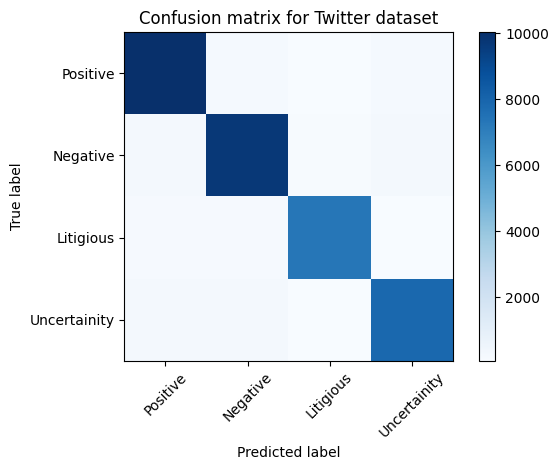

313/313 [==============================] - 1s 2ms/step


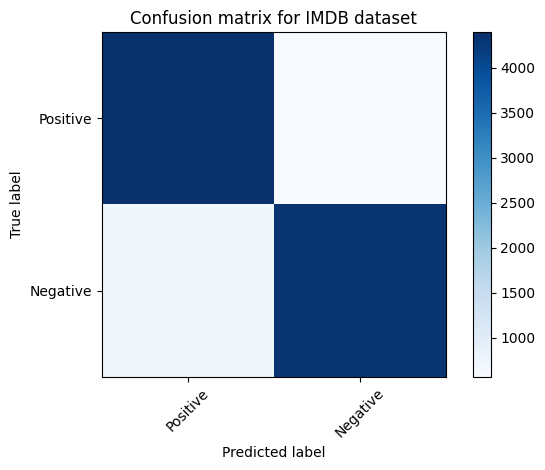

In [20]:
y_pred_twit = tf.argmax(simple_ann_model_twit.predict(X_test_twit), axis=-1)
y_true_twit = tf.argmax(y_test_twit, axis=-1)

from sklearn.metrics import confusion_matrix

cm_twit = confusion_matrix(y_true_twit, y_pred_twit)

import matplotlib.pyplot as plt
plt.close("all")
plt.imshow(cm_twit, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for Twitter dataset')
plt.colorbar()
tick_marks = np.arange(len(classes_twitter))
plt.xticks(tick_marks, classes_twitter, rotation=45)
plt.yticks(tick_marks, classes_twitter)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

y_pred_imdb = tf.argmax(simple_ann_model_imdb.predict(X_test_imdb), axis=-1)
y_true_imdb = tf.argmax(y_test_imdb, axis=-1)

cm_imdb = confusion_matrix(y_true_imdb, y_pred_imdb)

plt.imshow(cm_imdb, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for IMDB dataset')
plt.colorbar()
tick_marks = np.arange(len(classes_imdb))
plt.xticks(tick_marks, classes_imdb, rotation=45)
plt.yticks(tick_marks, classes_imdb)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()




In [21]:
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Obtain the predicted probabilities for each input instance
y_pred_prob_twit = simple_ann_model_twit.predict(X_test_twit)

# Apply a threshold to convert the probabilities to binary labels_twitter
y_pred_twit = (y_pred_prob_twit >= 0.5).astype(int)

# Calculate the f1 score
f1_twit = f1_score(y_test_twit, y_pred_twit, average='micro')

# Calculate the precision score
precision_twit = precision_score(y_test_twit, y_pred_twit, average='micro')

# Calculate the recall score
recall_twit = recall_score(y_test_twit, y_pred_twit, average='micro')

# Calculate the accuracy score
accuracy_twit = accuracy_score(np.argmax(y_test_twit, axis=1), np.argmax(y_pred_twit, axis=1))

data_twit.append(["Simpe ANN", f1_twit, precision_twit, recall_twit, accuracy_twit])
# Print the scores
print("Stats for Twitter dataset")
print('F1 score: {:.4f}'.format(f1_twit))
print("Precision: {:.2f}%".format(precision_twit * 100))
print("Recall Score: {:.2f}".format(recall_twit))
print("Accuracy:", accuracy_twit)

# Obtain the predicted probabilities for each input instance
y_pred_prob_imdb = simple_ann_model_imdb.predict(X_test_imdb)

# Apply a threshold to convert the probabilities to binary labels_twitter
y_pred_imdb = (y_pred_prob_imdb >= 0.5).astype(int)

# Calculate the f1 score
f1_imdb = f1_score(y_test_imdb, y_pred_imdb, average='micro')

# Calculate the precision score
precision_imdb = precision_score(y_test_imdb, y_pred_imdb, average='micro')

# Calculate the recall score
recall_imdb = recall_score(y_test_imdb, y_pred_imdb, average='micro')

# Calculate the accuracy score
accuracy_imdb = accuracy_score(np.argmax(y_test_imdb, axis=1), np.argmax(y_pred_imdb, axis=1))

data_imdb.append(["Simpe ANN", f1_imdb, precision_imdb, recall_imdb, accuracy_imdb])
# Print the scores
print("Stats for IMDB dataset")
print('F1 score: {:.4f}'.format(f1_imdb))
print("Precision: {:.2f}%".format(precision_imdb * 100))
print("Recall Score: {:.2f}".format(recall_imdb))
print("Accuracy:", accuracy_imdb)



1163/1163 [==============================] - 3s 2ms/step
Stats for Twitter dataset
F1 score: 0.9380
Precision: 93.68%
Recall Score: 0.94
Accuracy: 0.9349269945413966
313/313 [==============================] - 1s 2ms/step
Stats for IMDB dataset
F1 score: 0.8720
Precision: 87.22%
Recall Score: 0.87
Accuracy: 0.8719


In [22]:
def prediction(model, s, dataset_name):
    s = translate_text(s)
    s = clean_text(s)
    print(s)
    sequences = tokenizer.texts_to_sequences([s])
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    x = model.predict(padded)[0]
    if dataset_name == "Twitter":
        return classes_twitter[np.argmax(x)] + ", Confidence: " + str(x[np.argmax(x)])
    else:
        return classes_imdb[np.argmax(x)] + ", Confidence: " + str(x[np.argmax(x)])

In [23]:
print(prediction(simple_ann_model_twit, "yeh bilkul bhe bura nahi hai", "Twitter"))

# print(prediction(simple_ann_model_imdb, "I love this", "IMDB"))

not bad
1/1 [==============================] - 0s 29ms/step
Negative, Confidence: 0.9984337


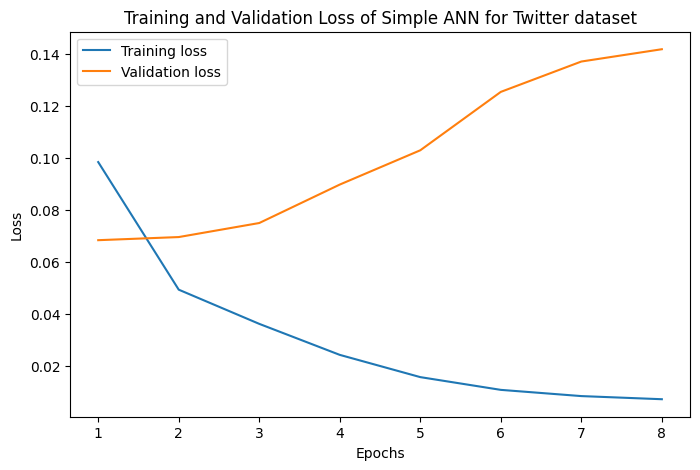

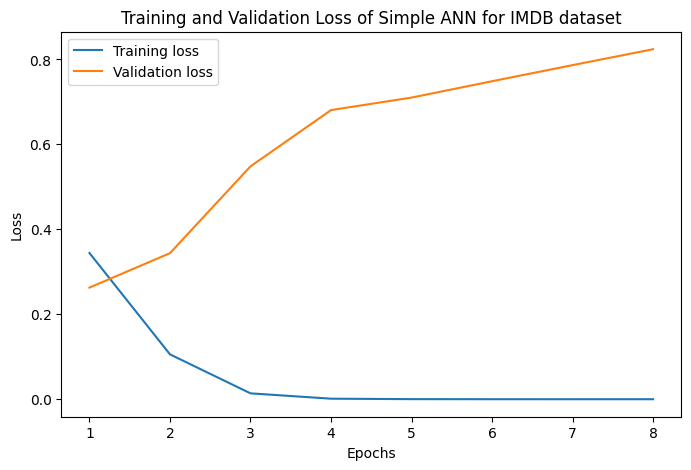

In [24]:
import matplotlib.pyplot as plt
plt.close('all')
train_loss = simple_ann_model_twit_history['loss']
val_loss = simple_ann_model_twit_history['val_loss']
fig, ax = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss) + 1)
ax.plot(epochs, train_loss, label='Training loss')
ax.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss of Simple ANN for Twitter dataset')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

train_loss = simple_ann_model_imdb_history['loss']
val_loss = simple_ann_model_imdb_history['val_loss']
fig, ax = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss) + 1)
ax.plot(epochs, train_loss, label='Training loss')
ax.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss of Simple ANN for IMDB dataset')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()


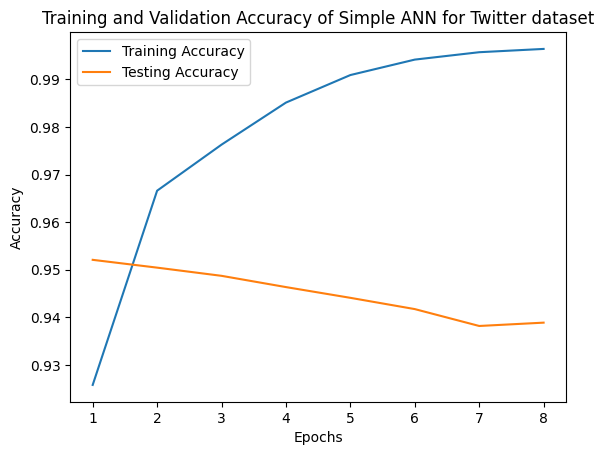

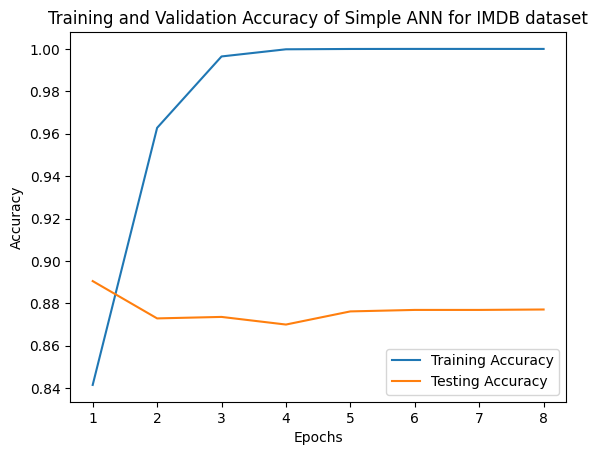

In [25]:

# Retrieve accuracy values from history object
plt.close('all')

train_acc = simple_ann_model_twit_history['accuracy']
test_acc = simple_ann_model_twit_history['val_accuracy']

# Retrieve number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and testing accuracy values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, test_acc, label='Testing Accuracy')
plt.title('Training and Validation Accuracy of Simple ANN for Twitter dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Retrieve accuracy values from history object
plt.close('all')

train_acc = simple_ann_model_imdb_history['accuracy']
test_acc = simple_ann_model_imdb_history['val_accuracy']

# Retrieve number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and testing accuracy values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, test_acc, label='Testing Accuracy')
plt.title('Training and Validation Accuracy of Simple ANN for IMDB dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




# CNN Model

In [26]:
from keras.layers import Conv1D,MaxPooling1D,BatchNormalization,Dropout,GlobalMaxPooling1D,Dense
from tensorflow.keras.initializers import RandomNormal, Constant

In [27]:
# Neural Network architecture

models_twit.append("CNN Model Twitter" )

# cnn_model_twit = tf.keras.Sequential()

# embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)

# cnn_model_twit.add(embedding_layer)

# cnn_model_twit.add(Conv1D(156, 5, activation='relu'))
# cnn_model_twit.add(MaxPooling1D(pool_size=3,strides=1, padding='same'))
# cnn_model_twit.add(BatchNormalization(momentum=0.95, epsilon=0.005,beta_initializer=RandomNormal(mean=0.0, stddev=0.05), gamma_initializer=Constant(value=0.9)))
# cnn_model_twit.add(GlobalMaxPooling1D())
# cnn_model_twit.add(Dropout(0.2))
# cnn_model_twit.add(Dense(4, activation='sigmoid'))


# cnn_model_twit.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Load the entier model
cnn_model_twit = tf.keras.models.load_model('./models/cnn_model_twit.h5')

print(cnn_model_twit.summary())

models_imdb.append("CNN Model IMDB")

# cnn_model_imdb = tf.keras.Sequential()

# embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)

# cnn_model_imdb.add(embedding_layer)

# cnn_model_imdb.add(Conv1D(156, 5, activation='relu'))
# cnn_model_imdb.add(MaxPooling1D(pool_size=3,strides=1, padding='same'))
# cnn_model_imdb.add(BatchNormalization(momentum=0.95, epsilon=0.005,beta_initializer=RandomNormal(mean=0.0, stddev=0.05), gamma_initializer=Constant(value=0.9)))
# cnn_model_imdb.add(GlobalMaxPooling1D())
# cnn_model_imdb.add(Dropout(0.2))
# cnn_model_imdb.add(Dense(2, activation='sigmoid'))


# cnn_model_imdb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Load the entier model
cnn_model_imdb = tf.keras.models.load_model('./models/cnn_model_imdb.h5')

print(cnn_model_imdb.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 32)           960000    
                                                                 
 conv1d (Conv1D)             (None, 296, 156)          25116     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 296, 156)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 296, 156)         624       
 ormalization)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 156)              0         
 lMaxPooling1D)                                                  
                                                      

In [28]:
# cnn_model_twit_history = cnn_model_twit.fit(X_train_twit, y_train_twit, batch_size = 156, epochs=total_epochs, validation_data=(X_test_twit, y_test_twit))
# # save the twitter model
# cnn_model_twit.save('./models/cnn_model_twit.h5')

# # save the histoy using pickle
# with open('./models/cnn_model_twit_history.pickle', 'wb') as file_pi:
#     pickle.dump(cnn_model_twit_history.history, file_pi)

# load the history using pickle
with open('./models/cnn_model_twit_history.pickle', 'rb') as file_pi:
    cnn_model_twit_history = pickle.load(file_pi)

In [29]:
# cnn_model_imdb_history = cnn_model_imdb.fit(X_train_imdb, y_train_imdb, batch_size = 156, epochs=total_epochs, validation_data=(X_test_imdb, y_test_imdb))

# # save the imdb model
# cnn_model_imdb.save('./models/cnn_model_imdb.h5')

# # save the history using pickel
# with open('./models/cnn_model_imdb_history.pickle', 'wb') as handle:
#    pickle.dump(cnn_model_twit_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL) 

# # load the history using pickle
with open('./models/cnn_model_imdb_history.pickle', 'rb') as handle:
   cnn_model_imdb_history = pickle.load(handle)

1163/1163 [==============================] - 8s 7ms/step


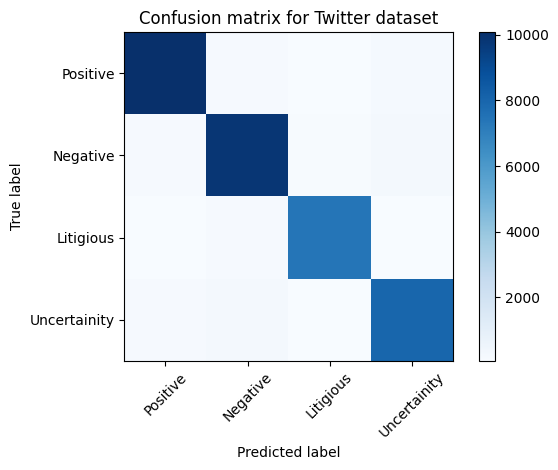

313/313 [==============================] - 2s 6ms/step


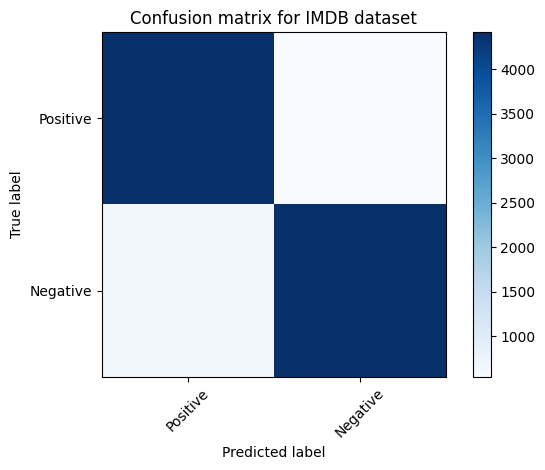

In [30]:
y_pred_twit = tf.argmax(cnn_model_twit.predict(X_test_twit), axis=-1)
y_true_twit = tf.argmax(y_test_twit, axis=-1)


cm_twit = confusion_matrix(y_true_twit, y_pred_twit)

import matplotlib.pyplot as plt
plt.close("all")
plt.imshow(cm_twit, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for Twitter dataset')
plt.colorbar()
tick_marks = np.arange(len(classes_twitter))
plt.xticks(tick_marks, classes_twitter, rotation=45)
plt.yticks(tick_marks, classes_twitter)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

y_pred_imdb = tf.argmax(cnn_model_imdb.predict(X_test_imdb), axis=-1)
y_true_imdb = tf.argmax(y_test_imdb, axis=-1)


cm_imdb = confusion_matrix(y_true_imdb, y_pred_imdb)

import matplotlib.pyplot as plt

plt.close("all")
plt.imshow(cm_imdb, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for IMDB dataset')
plt.colorbar()
tick_marks = np.arange(len(classes_imdb))
plt.xticks(tick_marks, classes_imdb, rotation=45)
plt.yticks(tick_marks, classes_imdb)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()



In [31]:
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Obtain the predicted probabilities for each input instance
y_pred_prob_twit = cnn_model_twit.predict(X_test_twit)

# Apply a threshold to convert the probabilities to binary labels_twitter
y_pred_twit = (y_pred_prob_twit >= 0.5).astype(int)

# Calculate the f1 score
f1_twit = f1_score(y_test_twit, y_pred_twit, average='micro')

# Calculate the precision score
precision_twit = precision_score(y_test_twit, y_pred_twit, average='micro')

# Calculate the recall score
recall_twit = recall_score(y_test_twit, y_pred_twit, average='micro')

# Calculate the accuracy score
accuracy_twit = accuracy_score(np.argmax(y_test_twit, axis=1), np.argmax(y_pred_twit, axis=1))

data_twit.append(["CNN", f1_twit, precision_twit, recall_twit, accuracy_twit])


# Print the scores
print("Stats for CNN model on Twitter dataset")
print('F1 score: {:.4f}'.format(f1_twit))
print("Precision: {:.2f}%".format(precision_twit * 100))
print("Recall Score: {:.2f}".format(recall_twit))
print("Accuracy:", accuracy_twit)

# Obtain the predicted probabilities for each input instance
y_pred_prob_imdb = cnn_model_imdb.predict(X_test_imdb)

# Apply a threshold to convert the probabilities to binary labels_twitter
y_pred_imdb = (y_pred_prob_imdb >= 0.5).astype(int)

# Calculate the f1 score
f1_imdb = f1_score(y_test_imdb, y_pred_imdb, average='micro')

# Calculate the precision score
precision_imdb = precision_score(y_test_imdb, y_pred_imdb, average='micro')

# Calculate the recall score
recall_imdb = recall_score(y_test_imdb, y_pred_imdb, average='micro')

# Calculate the accuracy score
accuracy_imdb = accuracy_score(np.argmax(y_test_imdb, axis=1), np.argmax(y_pred_imdb, axis=1))

data_imdb.append(["CNN", f1_imdb, precision_imdb, recall_imdb, accuracy_imdb])


# Print the scores
print("Stats for CNN model on IMDB dataset")
print('F1 score: {:.4f}'.format(f1_imdb))
print("Precision: {:.2f}%".format(precision_imdb * 100))
print("Recall Score: {:.2f}".format(recall_imdb))
print("Accuracy:", accuracy_imdb)



1163/1163 [==============================] - 7s 6ms/step
Stats for CNN model on Twitter dataset
F1 score: 0.9491
Precision: 95.51%
Recall Score: 0.94
Accuracy: 0.9436123584931028
313/313 [==============================] - 2s 6ms/step
Stats for CNN model on IMDB dataset
F1 score: 0.8825
Precision: 88.27%
Recall Score: 0.88
Accuracy: 0.8824


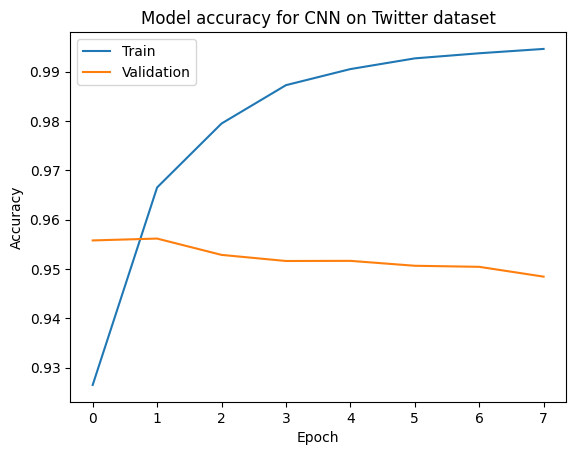

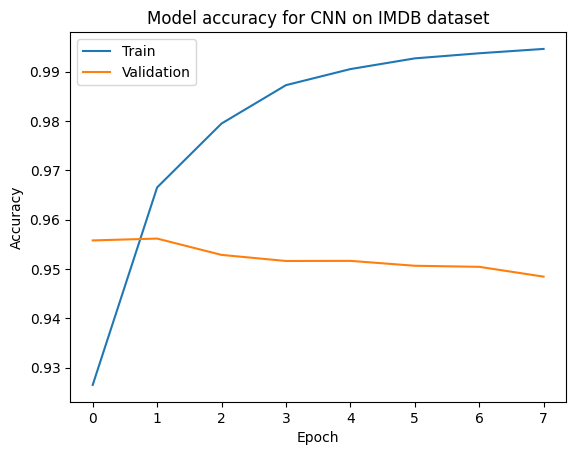

In [32]:
# Plot the training and validation accuracy over epochs
plt.close('all')
plt.plot(cnn_model_twit_history['acc'])
plt.plot(cnn_model_twit_history['val_acc'])
plt.title('Model accuracy for CNN on Twitter dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot the training and validation accuracy over epochs

plt.plot(cnn_model_imdb_history['acc'])
plt.plot(cnn_model_imdb_history['val_acc'])
plt.title('Model accuracy for CNN on IMDB dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



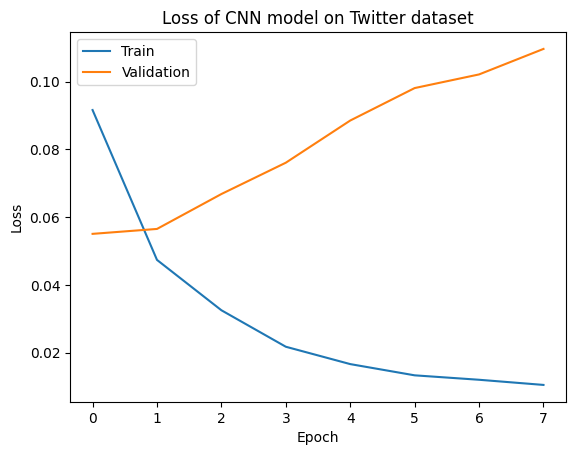

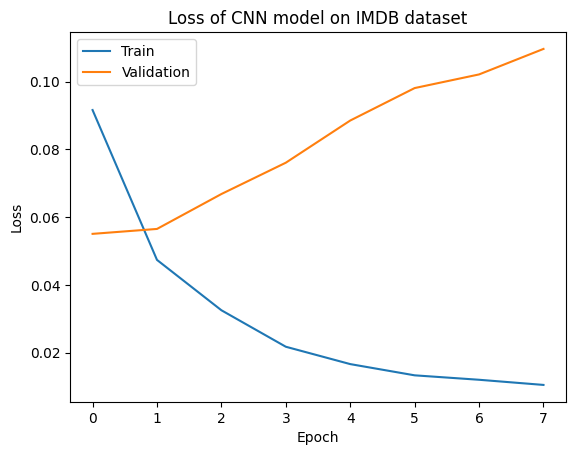

In [33]:
# Plot the training and validation loss over epochs
plt.close('all')
plt.plot(cnn_model_twit_history['loss'])
plt.plot(cnn_model_twit_history['val_loss'])
plt.title('Loss of CNN model on Twitter dataset')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot the training and validation loss over epochs
plt.plot(cnn_model_imdb_history['loss'])
plt.plot(cnn_model_imdb_history['val_loss'])
plt.title('Loss of CNN model on IMDB dataset')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




# BILSTM

In [34]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding
from tensorflow.keras.models import Sequential

models_twit.append("BiLSTM Model Twitter")

# bilstm_model_twit = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
#     tf.keras.layers.Dense(4, activation='sigmoid')
# ])

# # Compile the model
# bilstm_model_twit.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# load the model
bilstm_model_twit = tf.keras.models.load_model('./models/bilstm_model_twit.h5') 

print(bilstm_model_twit.summary())

models_imdb.append("BiLSTM Model IMDB")

# bilstm_model_imdb = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
#     tf.keras.layers.Dense(2, activation='sigmoid')
# ])

# # Compile the model
# bilstm_model_imdb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# load the model
bilstm_model_imdb = tf.keras.models.load_model('./models/bilstm_model_imdb.h5')

print(bilstm_model_imdb.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 32)           960000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1,010,180
Trainable params: 1,010,180
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 32)           960000    
                 

In [35]:
# bilstm_model_twit_history = bilstm_model_twit.fit(X_train_twit, y_train_twit, batch_size=128, epochs=total_epochs, verbose=1, validation_data=(X_test_twit, y_test_twit))


# # Save the model
# bilstm_model_twit.save('./models/bilstm_model_twit.h5')
# # Save the histoy 
# with open('./models/bilstm_model_twit_history.pkl', 'wb') as file_pi:
#     pickle.dump(bilstm_model_twit_history.history, file_pi)

# load the history
with open('./models/bilstm_model_twit_history.pkl', 'rb') as file_pi:
    bilstm_model_twit_history = pickle.load(file_pi)
    

In [36]:
# bilstm_model_imdb_history = bilstm_model_imdb.fit(X_train_imdb, y_train_imdb, batch_size=128, epochs=total_epochs, verbose=1, validation_data=(X_test_imdb, y_test_imdb))

# # Save the model
# bilstm_model_imdb.save('./models/bilstm_model_imdb.h5')
# # Save the histoy
# with open('./models/bilstm_model_imdb_history.pkl', 'wb') as file_pi:
#     pickle.dump(bilstm_model_imdb_history.history, file_pi)

# load the history
with open('./models/bilstm_model_imdb_history.pkl', 'rb') as file_pi:
    bilstm_model_imdb_history = pickle.load(file_pi)


1163/1163 [==============================] - 37s 31ms/step


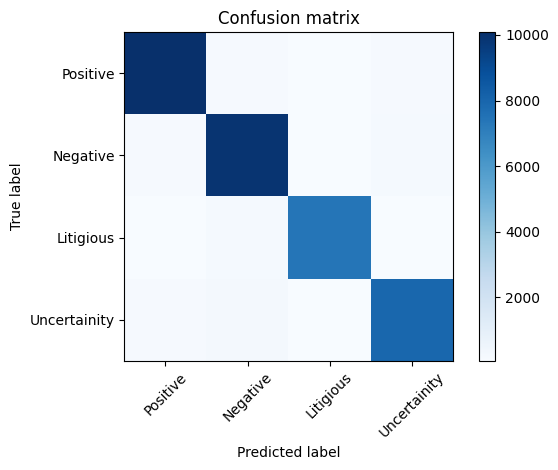

313/313 [==============================] - 10s 31ms/step


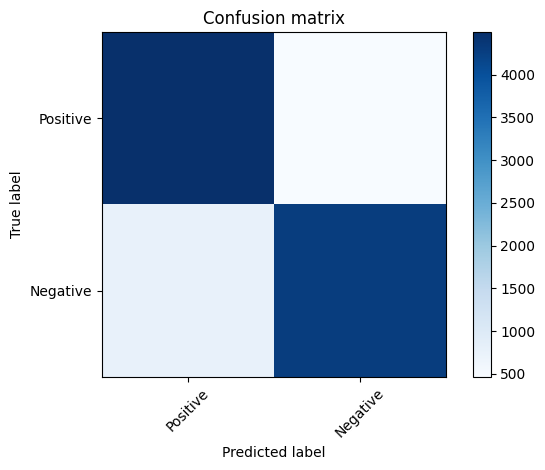

In [37]:
y_pred_twit = tf.argmax(bilstm_model_twit.predict(X_test_twit), axis=-1)
y_true_twit = tf.argmax(y_test_twit, axis=-1)

from sklearn.metrics import confusion_matrix

cm_twit = confusion_matrix(y_true_twit, y_pred_twit)

plt.close("all")
plt.imshow(cm_twit, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes_twitter))
plt.xticks(tick_marks, classes_twitter, rotation=45)
plt.yticks(tick_marks, classes_twitter)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

y_pred_imdb = tf.argmax(bilstm_model_imdb.predict(X_test_imdb), axis=-1)
y_true_imdb = tf.argmax(y_test_imdb, axis=-1)

cm_imdb = confusion_matrix(y_true_imdb, y_pred_imdb)

plt.imshow(cm_imdb, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes_imdb))
plt.xticks(tick_marks, classes_imdb, rotation=45)
plt.yticks(tick_marks, classes_imdb)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()




In [38]:
# Obtain the predicted probabilities for each input instance
y_pred_prob_twit = bilstm_model_twit.predict(X_test_twit)

# Apply a threshold to convert the probabilities to binary labels_twitter
y_pred_twit = (y_pred_prob_twit >= 0.5).astype(int)

# Calculate the f1 score
f1_twit = f1_score(y_test_twit, y_pred_twit, average='micro')

# Calculate the precision score
precision_twit = precision_score(y_test_twit, y_pred_twit, average='micro')

# Calculate the recall score
recall_twit = recall_score(y_test_twit, y_pred_twit, average='micro')

# Calculate the accuracy score
accuracy_twit = accuracy_score(np.argmax(y_test_twit, axis=1), np.argmax(y_pred_twit, axis=1))

data_twit.append(["BiLSTM", f1_twit, precision_twit, recall_twit, accuracy_twit])


# Print the scores
print('Stats for BiLSTM model on Twitter dataset')
print('F1 score: {:.4f}'.format(f1_twit))
print("Precision: {:.2f}%".format(precision_twit * 100))
print("Recall Score: {:.2f}".format(recall_twit))
print("Accuracy:", accuracy_twit)

# Obtain the predicted probabilities for each input instance
y_pred_prob_imdb = bilstm_model_imdb.predict(X_test_imdb)

# Apply a threshold to convert the probabilities to binary labels_imdb
y_pred_imdb = (y_pred_prob_imdb >= 0.5).astype(int)

# Calculate the f1 score
f1_imdb = f1_score(y_test_imdb, y_pred_imdb, average='micro')

# Calculate the precision score
precision_imdb = precision_score(y_test_imdb, y_pred_imdb, average='micro')

# Calculate the recall score
recall_imdb = recall_score(y_test_imdb, y_pred_imdb, average='micro')

# Calculate the accuracy score
accuracy_imdb = accuracy_score(np.argmax(y_test_imdb, axis=1), np.argmax(y_pred_imdb, axis=1))

data_imdb.append(["BiLSTM", f1_imdb, precision_imdb, recall_imdb, accuracy_imdb])

# Print the scores
print('Stats for BiLSTM model on IMDB dataset')
print('F1 score: {:.4f}'.format(f1_imdb))
print("Precision: {:.2f}%".format(precision_imdb * 100))
print("Recall Score: {:.2f}".format(recall_imdb))
print("Accuracy:", accuracy_imdb)



1163/1163 [==============================] - 36s 31ms/step
Stats for BiLSTM model on Twitter dataset
F1 score: 0.9500
Precision: 95.17%
Recall Score: 0.95
Accuracy: 0.9484256097233053
313/313 [==============================] - 10s 31ms/step
Stats for BiLSTM model on IMDB dataset
F1 score: 0.8767
Precision: 87.68%
Recall Score: 0.88
Accuracy: 0.8765


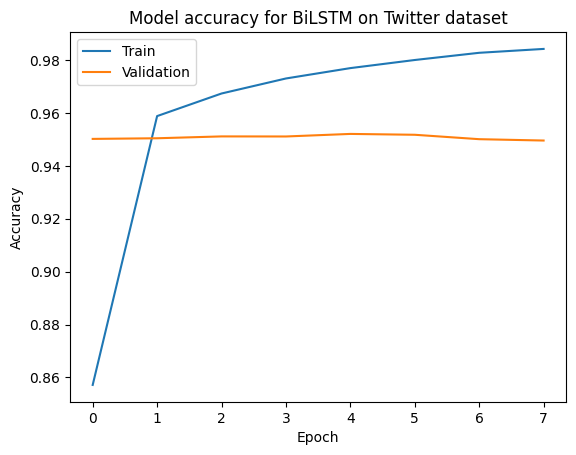

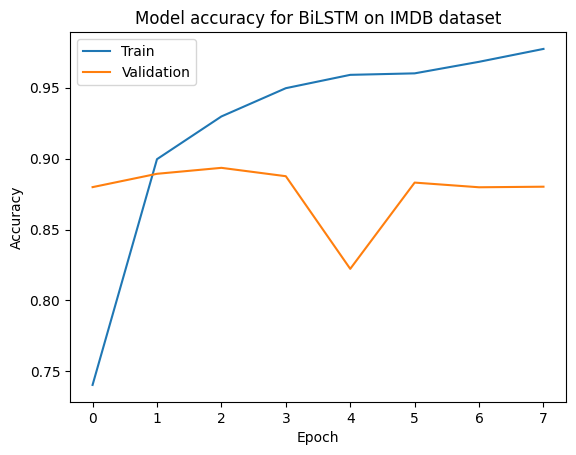

In [39]:
# Plot the training and validation accuracy over epochs
plt.close('all')
plt.plot(bilstm_model_twit_history['accuracy'])
plt.plot(bilstm_model_twit_history['val_accuracy'])
plt.title('Model accuracy for BiLSTM on Twitter dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation accuracy over epochs for IMDB
plt.plot(bilstm_model_imdb_history['accuracy'])
plt.plot(bilstm_model_imdb_history['val_accuracy'])
plt.title('Model accuracy for BiLSTM on IMDB dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



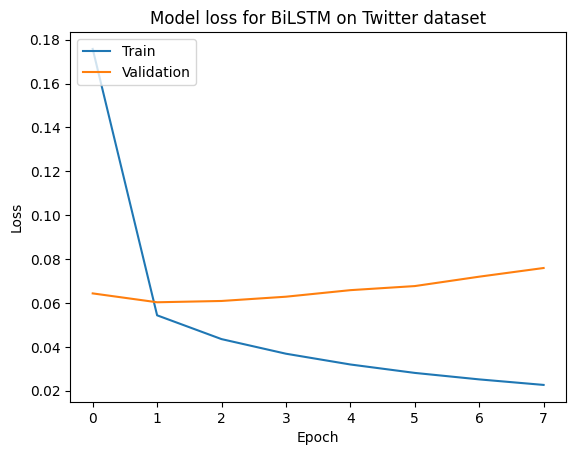

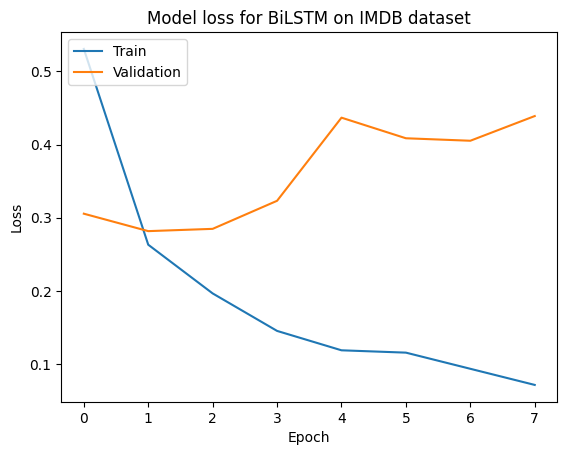

In [40]:
# Plot the training and validation loss over epochs
plt.close('all')
plt.plot(bilstm_model_twit_history['loss'])
plt.plot(bilstm_model_twit_history['val_loss'])
plt.title('Model loss for BiLSTM on Twitter dataset')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs for IMDB
plt.plot(bilstm_model_imdb_history['loss'])
plt.plot(bilstm_model_imdb_history['val_loss'])
plt.title('Model loss for BiLSTM on IMDB dataset')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Random Forest Classifier

# Results

In [41]:
train_acc_twit = []
val_acc_twit = []
train_loss_twit = []
val_loss_twit = []

train_acc_imdb = []
val_acc_imdb = []
train_loss_imdb = []
val_loss_imdb = []


train_acc_twit.append(simple_ann_model_twit_history['accuracy'])
val_acc_twit.append(simple_ann_model_twit_history['val_accuracy'])
train_loss_twit.append(simple_ann_model_twit_history['loss'])
val_loss_twit.append(simple_ann_model_twit_history['val_loss'])

train_acc_twit.append(cnn_model_twit_history['acc'])
val_acc_twit.append(cnn_model_twit_history['val_acc'])
train_loss_twit.append(cnn_model_twit_history['loss'])
val_loss_twit.append(cnn_model_twit_history['val_loss'])

train_acc_twit.append(bilstm_model_twit_history['accuracy'])
val_acc_twit.append(bilstm_model_twit_history['val_accuracy'])
train_loss_twit.append(bilstm_model_twit_history['loss'])
val_loss_twit.append(bilstm_model_twit_history['val_loss'])

train_acc_imdb.append(simple_ann_model_imdb_history['accuracy'])
val_acc_imdb.append(simple_ann_model_imdb_history['val_accuracy'])
train_loss_imdb.append(simple_ann_model_imdb_history['loss'])
val_loss_imdb.append(simple_ann_model_imdb_history['val_loss'])

train_acc_imdb.append(cnn_model_imdb_history['acc'])
val_acc_imdb.append(cnn_model_imdb_history['val_acc'])
train_loss_imdb.append(cnn_model_imdb_history['loss'])
val_loss_imdb.append(cnn_model_imdb_history['val_loss'])

train_acc_imdb.append(bilstm_model_imdb_history['accuracy'])
val_acc_imdb.append(bilstm_model_imdb_history['val_accuracy'])
train_loss_imdb.append(bilstm_model_imdb_history['loss'])
val_loss_imdb.append(bilstm_model_imdb_history['val_loss'])



In [42]:

accuracy_twit = []
accuracy_twit.append(max(simple_ann_model_twit_history['val_accuracy']))
accuracy_twit.append(max(cnn_model_twit_history['val_acc']))
accuracy_twit.append(max(bilstm_model_twit_history['val_accuracy']))


# Sample data
accuracy_twit = np.array(accuracy_twit)

# Convert to percent with one decimal place
accuracy_twit = np.round(accuracy_twit * 100, 1)

metrics = pd.DataFrame({
    'Models on Twitter': models_twit,
    'Accuracy': accuracy_twit,
})

# Set Model column as index
metrics = metrics.set_index('Models on Twitter')

# Display DataFrame
print(metrics)


accuracy_imdb = []
accuracy_imdb.append(max(simple_ann_model_imdb_history['val_accuracy']))
accuracy_imdb.append(max(cnn_model_imdb_history['val_acc']))
accuracy_imdb.append(max(bilstm_model_imdb_history['val_accuracy']))


# Sample data
accuracy_imdb = np.array(accuracy_imdb)

# Convert to percent with one decimal place
accuracy_imdb = np.round(accuracy_imdb * 100, 1)

metrics = pd.DataFrame({
    'Models on IMDB': models_imdb,
    'Accuracy': accuracy_imdb,
})

# Set Model column as index
metrics = metrics.set_index('Models on IMDB')

# Display DataFrame
print(metrics)



                       Accuracy
Models on Twitter              
Simple ANN on Twitter      95.2
CNN Model Twitter          95.6
BiLSTM Model Twitter       95.2
                    Accuracy
Models on IMDB              
Simple ANN on IMDB      89.1
CNN Model IMDB          95.6
BiLSTM Model IMDB       89.3


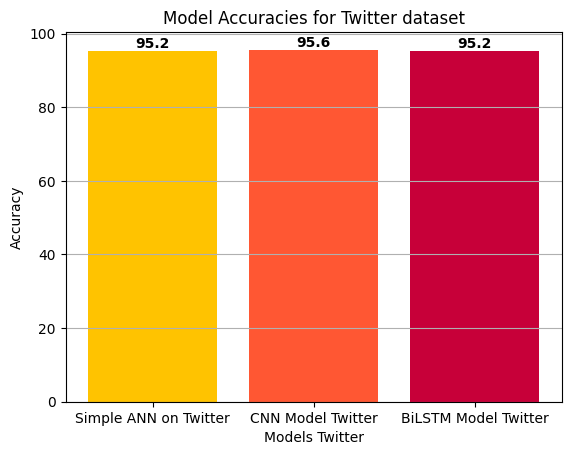

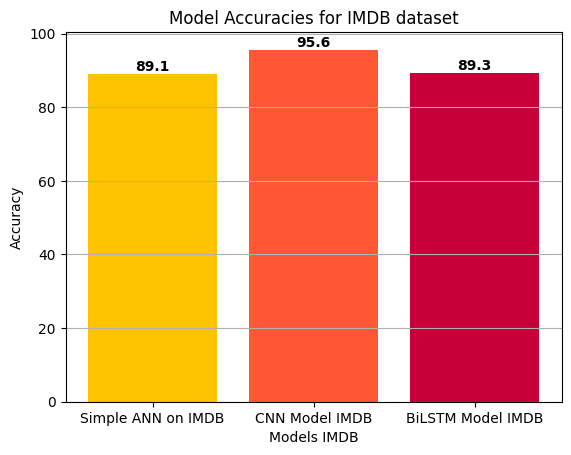

In [43]:
import matplotlib.pyplot as plt


# Create a bar chart
plt.close('all')
colors = ['#FFC300', '#FF5733', '#C70039']
plt.bar(models_twit, accuracy_twit, color=colors)

# Add horizontal grid lines
plt.grid(True, axis='y')

# Add a title and axis labels_twitter
plt.title('Model Accuracies for Twitter dataset')
plt.xlabel('Models Twitter')
plt.ylabel('Accuracy')

# Add value labels_twitter on top of each bar
for i, v in enumerate(accuracy_twit):
    plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Display the chart
plt.show()


# Create a bar chart
plt.close('all')
colors = ['#FFC300', '#FF5733', '#C70039']
plt.bar(models_imdb, accuracy_imdb, color=colors)

# Add horizontal grid lines
plt.grid(True, axis='y')

# Add a title and axis labels_twitter
plt.title('Model Accuracies for IMDB dataset')
plt.xlabel('Models IMDB')
plt.ylabel('Accuracy')

# Add value labels_twitter on top of each bar
for i, v in enumerate(accuracy_imdb):
    plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Display the chart
plt.show()


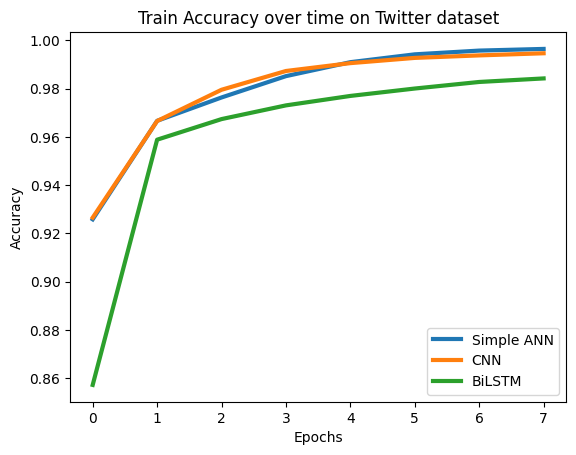

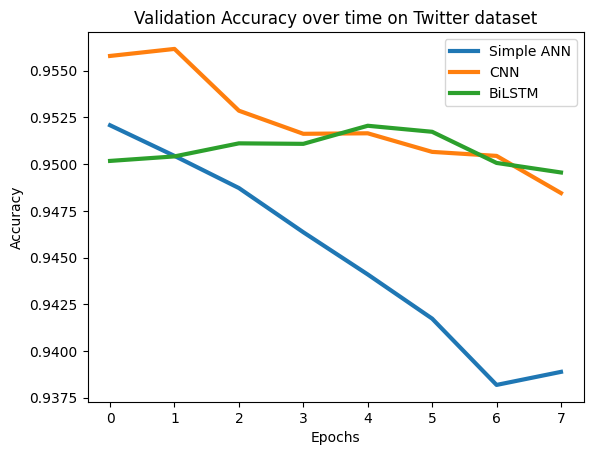

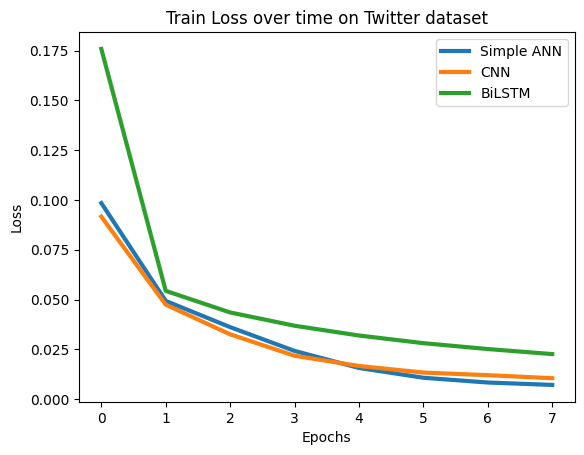

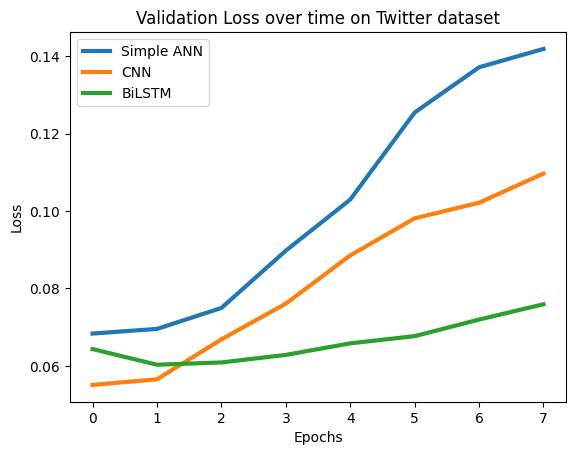

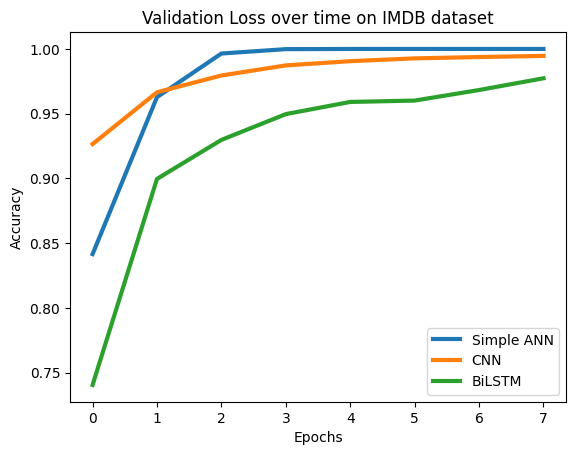

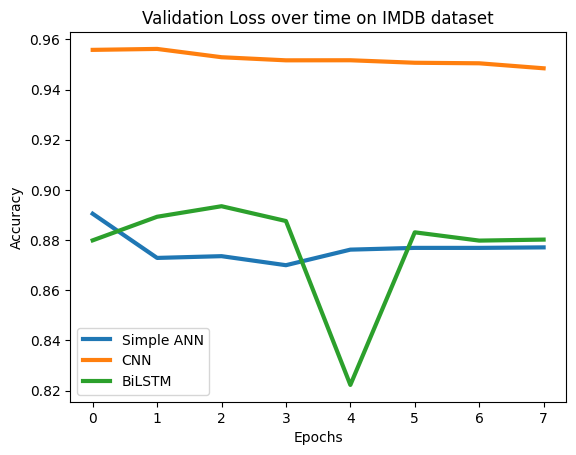

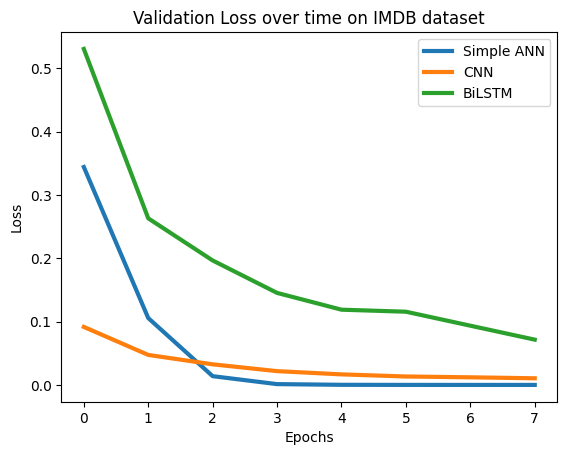

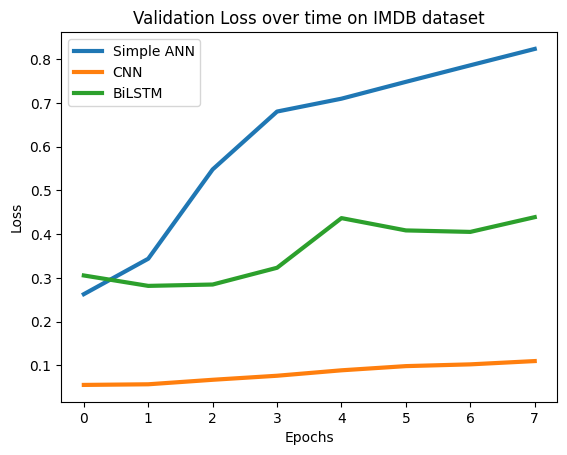

In [44]:
plt.close('all')

# Create the plot for train accuracy
x = range(len(train_acc_twit[0]))
fig1 = plt.figure()
plt.plot(x, train_acc_twit[0], label="Simple ANN", linewidth=3)
plt.plot(x, train_acc_twit[1], label="CNN", linewidth=3)
plt.plot(x, train_acc_twit[2], label="BiLSTM", linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy over time on Twitter dataset')


# Create the plot for validation accuracy
fig2 = plt.figure()
plt.plot(x, val_acc_twit[0], label="Simple ANN", linewidth=3)
plt.plot(x, val_acc_twit[1], label="CNN", linewidth=3)
plt.plot(x, val_acc_twit[2], label="BiLSTM", linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over time on Twitter dataset')

# Create the plot for train loss
fig3 = plt.figure()
plt.plot(x, train_loss_twit[0], label="Simple ANN", linewidth=3)
plt.plot(x, train_loss_twit[1], label="CNN", linewidth=3)
plt.plot(x, train_loss_twit[2], label="BiLSTM", linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss over time on Twitter dataset')

# Create the plot for validation loss
fig4 = plt.figure()
plt.plot(x, val_loss_twit[0], label="Simple ANN", linewidth=3)
plt.plot(x, val_loss_twit[1], label="CNN", linewidth=3)
plt.plot(x, val_loss_twit[2], label="BiLSTM", linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over time on Twitter dataset')

# Show all the plots
plt.show()



plt.close('all')

# Create the plot for train accuracy
x = range(len(train_acc_imdb[0]))
# print(x)
# sys.exit()
fig1 = plt.figure()
plt.plot(x, train_acc_imdb[0], label="Simple ANN", linewidth=3)
plt.plot(x, train_acc_imdb[1], label="CNN", linewidth=3)
plt.plot(x, train_acc_imdb[2], label="BiLSTM", linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Loss over time on IMDB dataset')



# Create the plot for validation accuracy
fig2 = plt.figure()
plt.plot(x, val_acc_imdb[0], label="Simple ANN", linewidth=3)
plt.plot(x, val_acc_imdb[1], label="CNN", linewidth=3)
plt.plot(x, val_acc_imdb[2], label="BiLSTM", linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Loss over time on IMDB dataset')


# Create the plot for train loss
fig3 = plt.figure()
plt.plot(x, train_loss_imdb[0], label="Simple ANN", linewidth=3)
plt.plot(x, train_loss_imdb[1], label="CNN", linewidth=3)
plt.plot(x, train_loss_imdb[2], label="BiLSTM", linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over time on IMDB dataset')


# Create the plot for validation loss
fig4 = plt.figure()
plt.plot(x, val_loss_imdb[0], label="Simple ANN", linewidth=3)
plt.plot(x, val_loss_imdb[1], label="CNN", linewidth=3)
plt.plot(x, val_loss_imdb[2], label="BiLSTM", linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over time on IMDB dataset')


# Show all the plots
plt.show()


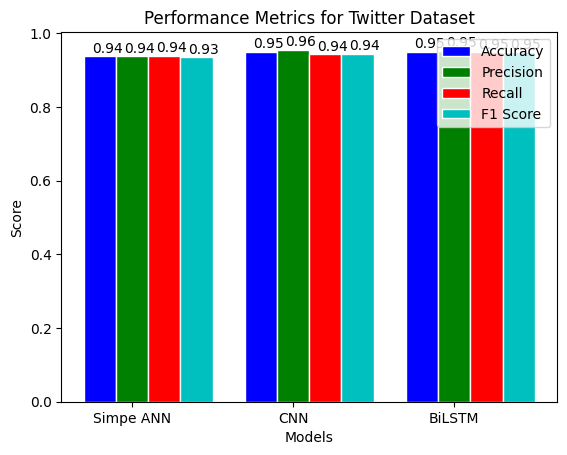

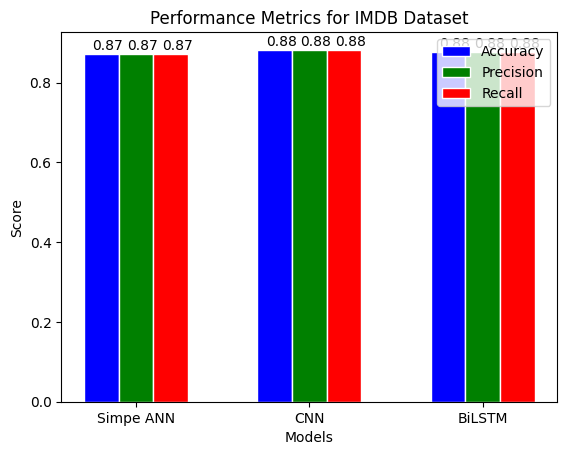

In [45]:
# extract the accuracy, precision, recall, and f1 values for each model
accuracy_twit = [x[1] for x in data_twit]
precision_twit = [x[2] for x in data_twit]
recall_twit = [x[3] for x in data_twit]
f1_twit = [x[4] for x in data_twit]

# set the width of the bars
barWidth = 0.2

# set the positions of the bars on the x-axis
r1 = np.arange(len(data_twit))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# create the bar chart
plt.bar(r1, accuracy_twit, color='b', width=barWidth, edgecolor='white', label='Accuracy')
plt.bar(r2, precision_twit, color='g', width=barWidth, edgecolor='white', label='Precision')
plt.bar(r3, recall_twit, color='r', width=barWidth, edgecolor='white', label='Recall')
plt.bar(r4, f1_twit, color='c', width=barWidth, edgecolor='white', label='F1 Score')

# add labels_twitter and titles
plt.xlabel('Models')
plt.xticks([r + barWidth for r in range(len(data_twit))], [x[0] for x in data_twit])
plt.ylabel('Score')
plt.title('Performance Metrics for Twitter Dataset')

# add legend
plt.legend()

# add text labels_twitter above each bar
for i in range(len(data_twit)):
    plt.text(r1[i] - 0.05, accuracy_twit[i] + 0.01, '{:.2f}'.format(accuracy_twit[i]), fontsize=10)
    plt.text(r2[i] - 0.05, precision_twit[i] + 0.01, '{:.2f}'.format(precision_twit[i]), fontsize=10)
    plt.text(r3[i] - 0.05, recall_twit[i] + 0.01, '{:.2f}'.format(recall_twit[i]), fontsize=10)
    plt.text(r4[i] - 0.05, f1_twit[i] + 0.01, '{:.2f}'.format(f1_twit[i]), fontsize=10)

# show the plot
plt.show()



# extract the accuracy, precision, recall, and f1 values for each model
accuracy_imdb = [x[1] for x in data_imdb]
precision_imdb = [x[2] for x in data_imdb]
recall_imdb = [x[3] for x in data_imdb]

# set the width of the bars
barWidth = 0.2

# set the positions of the bars on the x-axis
r1 = np.arange(len(data_imdb))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# create the bar chart
plt.bar(r1, accuracy_imdb, color='b', width=barWidth, edgecolor='white', label='Accuracy')

plt.bar(r2, precision_imdb, color='g', width=barWidth, edgecolor='white', label='Precision')

plt.bar(r3, recall_imdb, color='r', width=barWidth, edgecolor='white', label='Recall')

# add labels_twitter and titles
plt.xlabel('Models')
plt.xticks([r + barWidth for r in range(len(data_imdb))], [x[0] for x in data_imdb])
plt.ylabel('Score')
plt.title('Performance Metrics for IMDB Dataset')

# add legend
plt.legend()

# add text labels_twitter above each bar
for i in range(len(data_imdb)):
    plt.text(r1[i] - 0.05, accuracy_imdb[i] + 0.01, '{:.2f}'.format(accuracy_imdb[i]), fontsize=10)
    plt.text(r2[i] - 0.05, precision_imdb[i] + 0.01, '{:.2f}'.format(precision_imdb[i]), fontsize=10)
    plt.text(r3[i] - 0.05, recall_imdb[i] + 0.01, '{:.2f}'.format(recall_imdb[i]), fontsize=10)

# show the plot
plt.show()




introduction 5page
literature work 5-8page
proposed work- description of work done, steps : 10-15 pages
result analysis: define the reuslts model wise 5-8pages
conclusion and future work
refrences 15-20refs 


make a presentation of about 25-30 slides


In [46]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(simple_ann_model_twit, './API/nodeAPI/simple_ann_model_twit')
tfjs.converters.save_keras_model(cnn_model_twit, './API/nodeAPI/cnn_model_twit')
tfjs.converters.save_keras_model(bilstm_model_twit, './API/nodeAPI/bilstm_model_twit')

tfjs.converters.save_keras_model(simple_ann_model_imdb, './API/nodeAPI/simple_ann_model_imdb')
tfjs.converters.save_keras_model(cnn_model_imdb, './API/nodeAPI/cnn_model_imdb')
tfjs.converters.save_keras_model(bilstm_model_imdb, './API/nodeAPI/bilstm_model_imdb')



In [47]:
from langdetect import detect

text = " वैसा why it  is"

print(detect(text))


en


# Hybrid Model